# Importing library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Preparation of DNS data for the different ML techniques used (PySINDy and PINNs)

In [2]:
def Merged_DNS_data(csv1,csv2):
    """
    Merges two DNS datasets from CSV files. 

    Args:
        csv1 (str): Path to the first CSV file containing DNS data.
        csv2 (str): Path to the second CSV file containing DNS data.

    Returns:
        pd.DataFrame: A dataframe resulting from the merging of the two input dataframes
    """
    
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    
    df = pd.merge(df1, df2,  how='left', left_on=['y/delta','y^+','Re_tau'], right_on = ['y/delta','y^+','Re_tau'])
    
    return df

In [3]:
df = Merged_DNS_data("mean_combined_channel.csv","vel_fluc_combined_channel.csv")

# Select the specific DataFrame columns needed for PySINDy or PINNs
df = df[["y/delta","y^+","U","Re_tau","u'u'","v'v'","w'w'","u'v'","P","k","dU/dy"]] 
Reynolds_Number = df["Re_tau"].unique() # Obtain the different Reynolds numbers

df

,y/delta,y^+,U,Re_tau,u'u',v'v',w'w',u'v',P,k,dU/dy
0,0.000000,0.000000,0.000000,5185.897,4.176503e-36,0.000000e+00,-4.685007e-10,0.000000e+00,0.000000e+00,-2.342503e-10,1.000000
1,0.000014,0.071102,0.071102,5185.897,1.005730e-03,4.711429e-09,4.434640e-04,-3.980482e-07,-4.717272e-09,7.245992e-04,0.999986
2,0.000042,0.216250,0.216244,5185.897,9.271135e-03,3.846287e-07,3.959369e-03,-1.137182e-05,-3.851045e-07,6.615444e-03,0.999947
3,0.000085,0.438384,0.438355,5185.897,3.792464e-02,6.048292e-06,1.542633e-02,-9.679785e-05,-6.055743e-06,2.667851e-02,0.999819
4,0.000143,0.740447,0.740306,5185.897,1.075992e-01,4.471796e-05,4.099240e-02,-4.781457e-04,-4.477271e-05,7.431814e-02,0.999379
...,...,...,...,...,...,...,...,...,...,...,...
1691,0.924453,168.332085,18.229457,182.088,6.710482e-01,3.840753e-01,3.923507e-01,-6.992134e-02,-3.840753e-01,7.237371e-01,0.005679
1692,0.941219,171.385008,18.244917,182.088,6.573929e-01,3.819697e-01,3.873618e-01,-5.435220e-02,-3.819697e-01,7.133622e-01,0.004445
1693,0.958002,174.440956,18.256587,182.088,6.469951e-01,3.803884e-01,3.836718e-01,-3.880605e-02,-3.803884e-01,7.055277e-01,0.003189
1694,0.974796,177.499065,18.264396,182.088,6.400011e-01,3.793335e-01,3.812476e-01,-2.327609e-02,-3.793335e-01,7.002911e-01,0.001917


In [4]:
df.to_csv("DNS_Data.csv", index=False)

In [5]:
def plot(df, Reynolds_Numbers):
    """
    Plot the data for each Reynolds number.
    
    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        Reynolds_Numbers (list): The list of Reynolds numbers

    Returns:
        None
    """
    
    columns = ["U","u'u'","v'v'","w'w'","u'v'"]
    
    for col in columns:
        
        plt.figure(figsize=(12, 6))
        
        for Re in Reynolds_Numbers:
            subset = df[df["Re_tau"] == Re]
            
            if col == "u'v'":
                subset[col] = - subset[col]
            
            plt.plot(subset["y^+"], subset[col], label=f"Re={Re}")
        
        plt.xscale('log')
        plt.xlim(left=0.1, right = 10000)
        plt.xlabel('y^+')
        
        if col == "u'v'":
            plt.ylabel(f"- {col}")
            plt.title(f"- {col} as a function of y^+")
        else:
            plt.ylabel(col)
            plt.title(f"{col} as a function of y^+")
        
        plt.legend()
        plt.show()

Without Interpolation


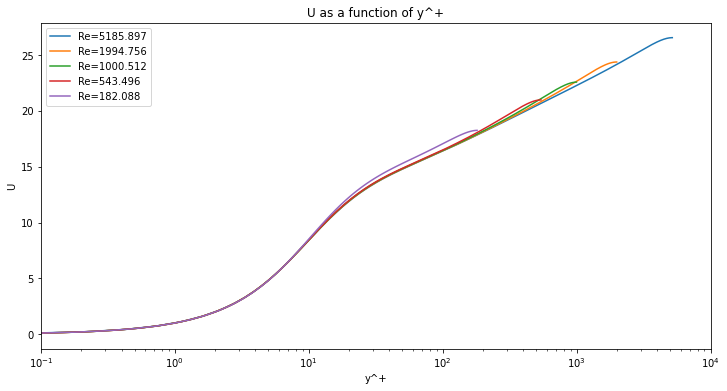

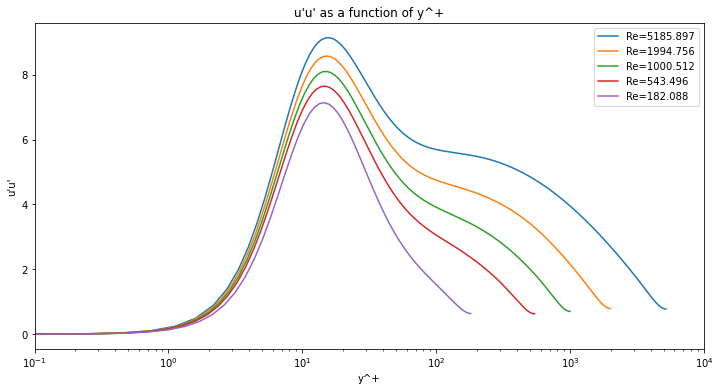

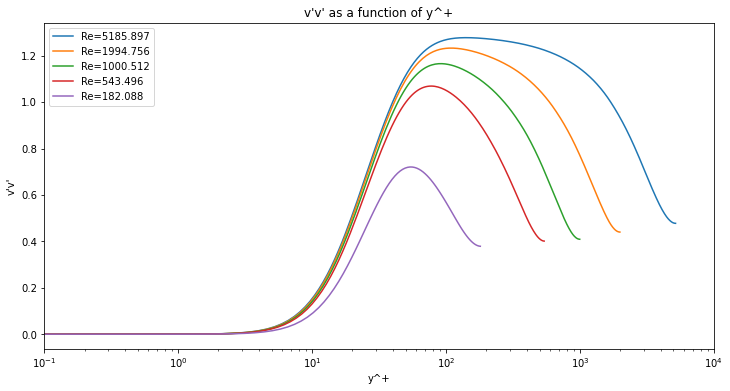

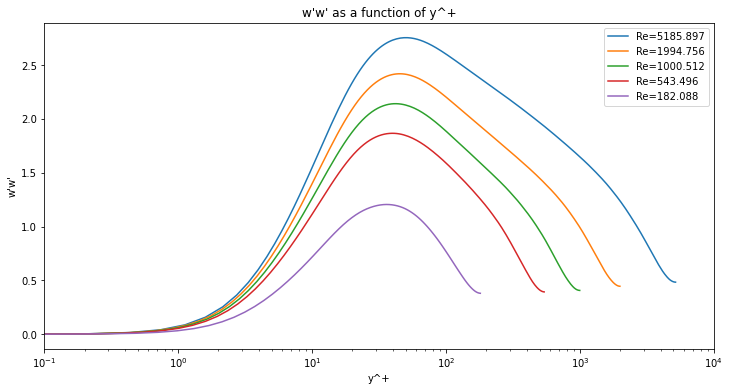

C:\Users\moi\AppData\Local\Temp/ipykernel_203312/1842980544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[col] = - subset[col]
C:\Users\moi\AppData\Local\Temp/ipykernel_203312/1842980544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[col] = - subset[col]
C:\Users\moi\AppData\Local\Temp/ipykernel_203312/1842980544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

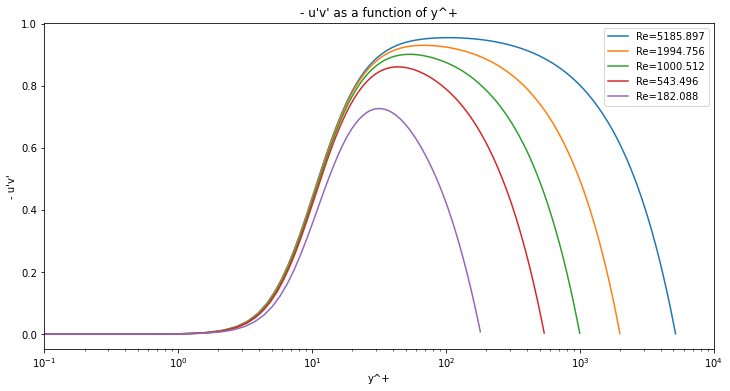

In [6]:
print("Without Interpolation")
plot(df,Reynolds_Number)

In [7]:
def data_interpolation(df,nb, Reynolds_Number):
    """
    Interpolates data for each column in the DataFrame over a specified number of points.
    
    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        nb (int): The number of points to interpolate
        Reynolds_Number (float): The Reynolds number to be assigned to the interpolated dataframe

    Returns:
        pd.DataFrame: The interpolated dataframe  
    """
    
    # Generate nb points for the 'y/delta' column to space it evenly from its minimum to its maximum value
    interval = np.linspace(df['y/delta'].min(), df['y/delta'].max(), num=nb)
    
    # Initialise a dictionary to contain the interpolated data
    interpolated_columns = {}
    
    # Interpolate the data in each column of the dataframe with the for loop
    for column in df.columns:
        if column != 'y/delta':
            # Create a interpolation function for each column
            f = interp1d(df['y/delta'], df[column], kind='linear') 
            # Apply the interpolation function
            interpolated_columns[column] = f(interval)
    
    # Create a dataframe with interpolated data
    df = pd.DataFrame(interpolated_columns)
    
    # Add the interpolated points y/delta and add the constant Reynolds number as columns in the dataframe
    df['y/delta'] = interval  
    df["Re_tau"] = Reynolds_Number
    
    return df

In [8]:
def Data_Preprocessing(df, nb_interpolation, Reynolds_Number):
    """
    Process and interpolate the DNS data for different Reynolds numbers

    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        nb_interpolation (int): The number of points to interpolate
        Reynolds_Numbers (list): The list of Reynolds numbers

    Returns:
        pd.DataFrame: The processed dataframe 
    """
    
    # Dictionary containing dataframes associated with a specific number of reynolds
    data = {f'df_{Re}': df[df["Re_tau"] == Re] for Re in Reynolds_Number}
    
    # Interpolate the data from each dataframe in the dictionary 
    for Re in Reynolds_Number:
        if nb_interpolation > len(data[f"df_{Re}"]):
            data[f"df_{Re}"] = data[f"df_{Re}"].drop(columns=["Re_tau"]) 
            data[f"df_{Re}"] = data_interpolation(data[f"df_{Re}"],nb_interpolation,Re)
        else:
            print("The number of points for interpolation is too small !!")

    # Concatenate all interpolated dataframes into a single dataframe
    df = pd.concat(data.values(), ignore_index=True)
    
    # list of friction velocities (u_tau) for different Reynolds numbers (from ODEN)
    u_tau = [4.14872e-02,  4.58794e-02, 5.00256e-02, 5.43496e-02, 6.37309e-02]

    # List of kinematic viscosities (nu) for different Reynolds numbers (from ODEN)
    nu = [8.00000e-06, 2.30000e-05, 5.00000e-05, 1.00000e-04, 3.50000e-04]

    # Adds the friction velocity (u_tau) and the kinematic viscosity columns to the DataFrame, assigning specific values based on the Reynolds number
    for i in range (len(Reynolds_Number)):
        df.loc[df["Re_tau"] == Reynolds_Number[i], "u_tau"] = u_tau[i]
        df.loc[df["Re_tau"] == Reynolds_Number[i], "nu"] = nu[i]
    
    # Calculate y^+ for each point
    df["y^+"] = df["y/delta"]*df["u_tau"]/df["nu"]
    # Calculate k for each point
    df["k"] = 0.5*(df["u'u'"]+df["v'v'"]+df["w'w'"])
    
    return df

# PySINDy

In [9]:
nb = 10000 # You can change the number of points to be generated for interpolation
df_PySINDy = Data_Preprocessing(df,nb, Reynolds_Number)
df_PySINDy

,y^+,U,u'u',v'v',w'w',u'v',P,k,dU/dy,y/delta,Re_tau,u_tau,nu
0,0.000000,0.000000,4.176503e-36,0.000000,-4.685007e-10,0.000000,0.000000,-2.342503e-10,1.000000,0.000000,5185.897,0.041487,0.000008
1,0.518124,0.518066,5.631775e-02,0.000016,2.217542e-02,-0.000197,-0.000016,3.925471e-02,0.999702,0.000100,5185.897,0.041487,0.000008
2,1.036249,1.035755,2.146491e-01,0.000173,7.611461e-02,-0.001431,-0.000173,1.454683e-01,0.998367,0.000200,5185.897,0.041487,0.000008
3,1.554373,1.552302,4.703307e-01,0.000694,1.508211e-01,-0.004692,-0.000695,3.109228e-01,0.995003,0.000300,5185.897,0.041487,0.000008
4,2.072498,2.066162,8.257437e-01,0.001886,2.396174e-01,-0.011195,-0.001888,5.336234e-01,0.988395,0.000400,5185.897,0.041487,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,180.486137,18.268216,6.365826e-01,0.378819,3.800729e-01,-0.008124,-0.378819,6.977371e-01,0.000670,0.991201,182.088,0.063731,0.000350
49996,180.504194,18.268239,6.365619e-01,0.378816,3.800658e-01,-0.008032,-0.378816,6.977216e-01,0.000662,0.991300,182.088,0.063731,0.000350
49997,180.522252,18.268262,6.365412e-01,0.378813,3.800587e-01,-0.007940,-0.378813,6.977062e-01,0.000655,0.991400,182.088,0.063731,0.000350
49998,180.540310,18.268285,6.365206e-01,0.378809,3.800516e-01,-0.007849,-0.378809,6.976908e-01,0.000647,0.991499,182.088,0.063731,0.000350


With Interpolation


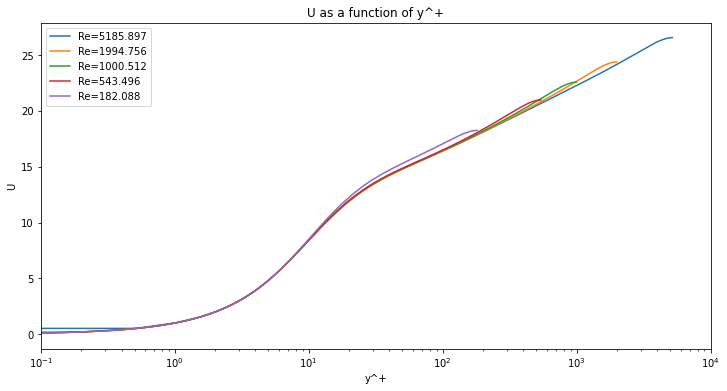

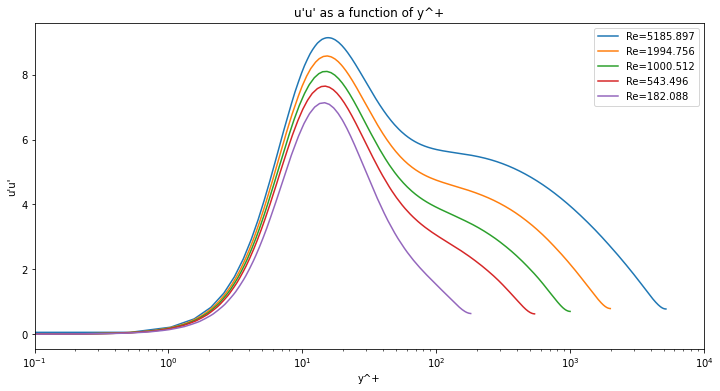

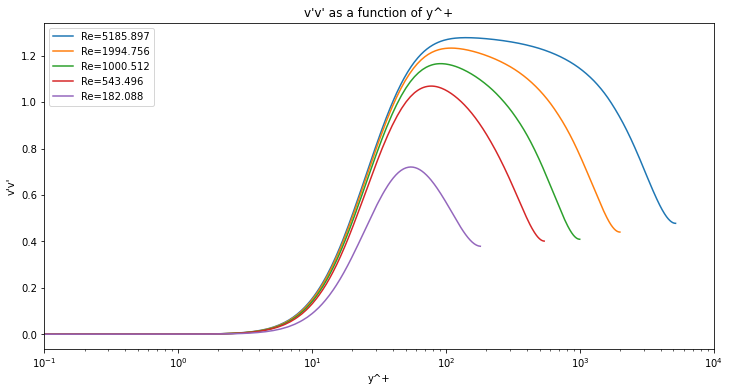

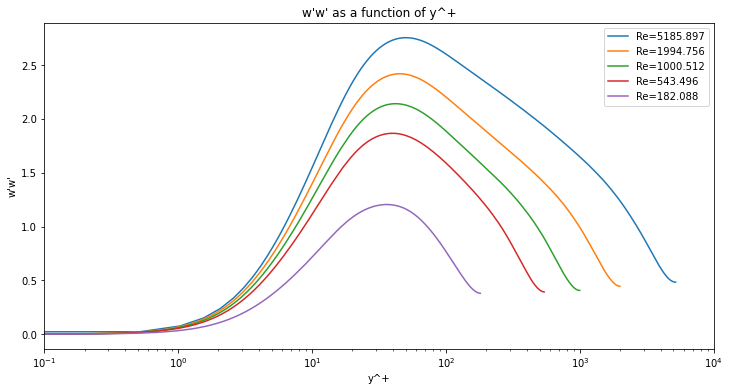

C:\Users\moi\AppData\Local\Temp/ipykernel_203312/1842980544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[col] = - subset[col]
C:\Users\moi\AppData\Local\Temp/ipykernel_203312/1842980544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[col] = - subset[col]
C:\Users\moi\AppData\Local\Temp/ipykernel_203312/1842980544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

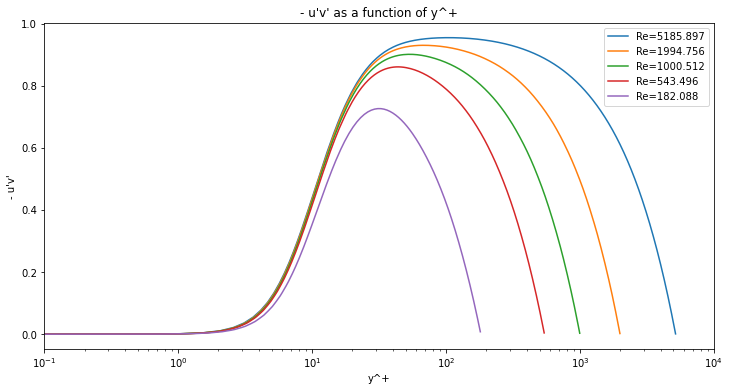

In [10]:
print("With Interpolation")
plot(df_PySINDy, Reynolds_Number)

In [11]:
# Save the DataFrame to use it when running the PySINDy model
df_PySINDy.to_csv("DNS_Data_PySINDy.csv",index=False)

# PINNs

In [12]:
# For PINNs, interpolation is not crucial
nb = 0 # You can change the number of points to be generated for interpolation
df_PINNs = Data_Preprocessing(df,nb, Reynolds_Number)
df_PINNs

The number of points for interpolation is too small !!
The number of points for interpolation is too small !!
The number of points for interpolation is too small !!
The number of points for interpolation is too small !!
The number of points for interpolation is too small !!


,y/delta,y^+,U,Re_tau,u'u',v'v',w'w',u'v',P,k,dU/dy,u_tau,nu
0,0.000000,0.000000,0.000000,5185.897,4.176503e-36,0.000000e+00,-4.685007e-10,0.000000e+00,0.000000e+00,-2.342503e-10,1.000000,0.041487,0.000008
1,0.000014,0.071102,0.071102,5185.897,1.005730e-03,4.711429e-09,4.434640e-04,-3.980482e-07,-4.717272e-09,7.245992e-04,0.999986,0.041487,0.000008
2,0.000042,0.216250,0.216244,5185.897,9.271135e-03,3.846287e-07,3.959369e-03,-1.137182e-05,-3.851045e-07,6.615444e-03,0.999947,0.041487,0.000008
3,0.000085,0.438384,0.438355,5185.897,3.792464e-02,6.048292e-06,1.542633e-02,-9.679785e-05,-6.055743e-06,2.667851e-02,0.999819,0.041487,0.000008
4,0.000143,0.740447,0.740306,5185.897,1.075992e-01,4.471796e-05,4.099240e-02,-4.781457e-04,-4.477271e-05,7.431814e-02,0.999379,0.041487,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,0.924453,168.331988,18.229457,182.088,6.710482e-01,3.840753e-01,3.923507e-01,-6.992134e-02,-3.840753e-01,7.237371e-01,0.005679,0.063731,0.000350
1692,0.941219,171.384909,18.244917,182.088,6.573929e-01,3.819697e-01,3.873618e-01,-5.435220e-02,-3.819697e-01,7.133622e-01,0.004445,0.063731,0.000350
1693,0.958002,174.440855,18.256587,182.088,6.469951e-01,3.803884e-01,3.836718e-01,-3.880605e-02,-3.803884e-01,7.055277e-01,0.003189,0.063731,0.000350
1694,0.974796,177.498963,18.264396,182.088,6.400011e-01,3.793335e-01,3.812476e-01,-2.327609e-02,-3.793335e-01,7.002911e-01,0.001917,0.063731,0.000350


In [13]:
df_PINNs = df_PINNs[df_PINNs["Re_tau"] == 1994.756] # You can change the Reynolds number

# Save the DataFrame to use it as a test dataset when testing the PINNs model
df_PINNs.to_csv("DNS_Data_PINNs_2000.csv", index=False)